# Imports and data loading

In [1]:
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

from statsmodels.stats.multitest import multipletests

sns.set(context="notebook", font_scale=1.15, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set_palette(sns.color_palette(colors))
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=True

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
anndataset = anndata.read(save_path + "spleen_lymph_206.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

# Filter out unanalyzed clusters
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset.obs["leiden_subclusters"]
]
anndataset = anndataset[include_cells]

In [3]:
dataset = AnnDatasetFromAnnData(ad = anndataset)
protein_data = CellMeasurement(name="protein_expression", data=anndataset.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset.uns["protein_names"])
dataset.initialize_cell_measurement(protein_data)

[2020-11-30 18:22:09,095] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-11-30 18:22:09,099] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-11-30 18:22:10,643] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-11-30 18:22:12,169] INFO - scvi.dataset.dataset | Downsampled from 8265 to 8265 cells


In [4]:
dataset.cell_types

array(['Ifit3-high CD8 T', 'MZ B', 'Transitional B', 'Mature B',
       'CD122+ CD8 T', 'Ifit3-high CD4 T', 'B1 B', 'CD4 T',
       'Ifit3-high B', 'GD T', 'Tregs', 'CD8 T', 'pDCs', 'NKT',
       'Migratory DCs', 'NK', 'Activated CD4 T', 'ICOS-high Tregs',
       'Ly6-high mono', 'Neutrophils', 'cDC2s', 'Ly6-low mono',
       'Red-pulp macrophages', 'Erythrocytes',
       'MZ/Marco-high macrophages', 'cDC1s', 'Plasma B'], dtype='<U128')

In [5]:
isotype_pros = [p.startswith("ADT_Isot") for p in dataset.protein_names]
print(sum(isotype_pros))

9


In [6]:
dataset.update_genes(dataset.var["hvg_encode"])

[2020-11-30 18:22:12,510] INFO - scvi.dataset.dataset | Downsampling from 13553 to 4005 genes
[2020-11-30 18:22:13,712] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-11-30 18:22:14,575] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-11-30 18:22:15,370] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-11-30 18:22:15,941] INFO - scvi.dataset.dataset | Downsampled from 8265 to 8265 cells


In [7]:
# Filter HTOs
non_control_proteins = []
for i, p in enumerate(dataset.protein_names):
    if not p.startswith("HTO"):
        non_control_proteins.append(i)
    else:
        print(p)
dataset.protein_expression = dataset.protein_expression[:, non_control_proteins]
dataset.protein_names = dataset.protein_names[non_control_proteins]

HTO_B6_LN_r4_206_A0301
HTO_B6_spl_r4_206_A0302


In [8]:
totalvae = TOTALVI(dataset.nb_genes, len(dataset.protein_names), n_latent=20)
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [9]:
totalvae.load_state_dict(torch.load("saved_models/206_d1.pt"))
totalvae.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4212, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [10]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

In [11]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.var.index = dataset.gene_names
post_adata.obsm["X_totalVI"] = latent_mean

# Run DE functions

In [12]:
# Call scvi function
per_cluster_de, cluster_id = full_posterior.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [13]:
no_bg = []
for c in range(len(per_cluster_de)):
    pro_rows = per_cluster_de[c].index.str.contains('Isoty')
    no_bg.append(np.sum(per_cluster_de[c].iloc[pro_rows]["bayes_factor"] >= 0.7))

In [14]:
c = 2
pro_rows = per_cluster_de[c].index.str.contains('Isoty')
per_cluster_de[c].iloc[pro_rows]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_IsotypeCtrlMouseIgG2a_k_A0091,0.3342,0.6658,-0.689250,0.782366,0.845874,-0.081281,0.0,1.141689,-3.130592,2.857082,...,2.015742,-2.502738,2.423441,1.426451,1.438596,0.754386,0.747342,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG2a_k_A0238,0.2702,0.7298,-0.993608,0.961332,1.118622,-0.140169,0.0,1.525636,-3.755358,3.644128,...,3.206520,-3.483651,3.349234,2.724696,2.784423,0.924426,0.923179,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG2b_k_A0095,0.2378,0.7622,-1.164779,0.997954,0.975996,0.025504,0.0,1.459695,-3.779954,3.597017,...,3.166993,-3.387578,3.297777,2.912281,2.962919,0.947368,0.944843,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG1_k_A0236,0.2182,0.7818,-1.276187,0.965319,1.665440,-0.398813,0.0,1.745027,-4.724886,4.377712,...,3.867532,-4.241484,4.026487,4.993252,5.203482,0.991903,0.988038,NaN,NaN,Transitional B
ADT_IsotypeCtrlMouseIgG1_k(FC)_A0090,0.0604,0.9396,-2.744465,0.549722,0.682304,-0.115880,0.0,0.738756,-4.322368,4.011489,...,0.000000,-4.322368,0.407465,2.059379,2.200425,0.844804,0.879187,NaN,NaN,Transitional B
ADT_IsotypeCtrlMouseIgG2b_k_A0092,0.0414,0.9586,-3.142193,0.543950,0.622516,-0.071904,0.0,0.631915,-3.917703,4.103477,...,0.000000,-3.661328,0.000000,1.468286,1.495614,0.747638,0.759968,NaN,NaN,Transitional B
ADT_IsotypeCtrlAPCRatIgG1_l_A0237,0.0072,0.9928,-4.926447,0.807137,0.533915,0.040206,0.0,0.544849,-7.603752,6.879910,...,0.000000,0.000000,0.000000,3.708502,3.545322,0.966262,0.964381,NaN,NaN,Transitional B
ADT_IsotypeCtrlArm.HamsterIgG_A0241,0.0028,0.9972,-5.875328,0.553180,0.961709,-0.014399,0.0,0.442515,-9.355140,7.818409,...,0.000000,0.000000,0.000000,2.566802,4.343700,0.905533,0.912148,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG2c_k_A0240,0.0014,0.9986,-6.569875,0.551752,0.502025,0.005223,0.0,0.220893,-3.554306,7.377146,...,0.000000,0.000000,0.000000,2.469636,1.435008,0.707152,0.755316,NaN,NaN,Transitional B


In [15]:
# Call scvi function
per_cluster_de_w_bg, cluster_id = full_posterior.one_vs_all_degenes(
#     cell_labels=np.asarray(post_adata.obs["leiden_totalVI_0.6"].values).astype(int).ravel(),
    min_cells=1,
    n_samples=5000,
    mode="change",
    delta=0.2,
    use_permutation=False,
    include_bg=True,
    sample_bern=False,
    eps=0
)

In [16]:
w_bg = []
for c in range(len(per_cluster_de_w_bg)):
    pro_rows = per_cluster_de_w_bg[c].index.str.contains('Isoty')
    w_bg.append(np.sum(per_cluster_de_w_bg[c].iloc[pro_rows]["bayes_factor"] >= 0.7))

In [17]:
c = 2
pro_rows = per_cluster_de_w_bg[c].index.str.contains('Isoty')
per_cluster_de_w_bg[c].iloc[pro_rows]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_IsotypeCtrlArm.HamsterIgG_A0241,0.1652,0.8348,-1.620035,2.738137,3.022099,-0.096824,-0.024784,0.303725,-3.288571,0.700005,...,0.245367,-1.498594,0.516439,2.566802,4.343700,0.905533,0.912148,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG2c_k_A0240,0.1246,0.8754,-1.949572,1.536651,1.452042,0.073561,0.036829,0.187756,-2.946228,2.466599,...,0.416825,-0.252339,0.991026,2.469636,1.435008,0.707152,0.755316,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG1_k_A0236,0.1236,0.8764,-1.958772,4.985637,5.212313,-0.060237,-0.038661,0.138104,-1.270371,0.923299,...,0.157100,-0.606970,0.289849,4.993252,5.203482,0.991903,0.988038,NaN,NaN,Transitional B
ADT_IsotypeCtrlAPCRatIgG1_l_A0237,0.1114,0.8886,-2.076520,3.743690,3.545451,0.075108,0.051507,0.110534,-0.358720,0.923839,...,0.318782,-0.170037,0.517405,3.708502,3.545322,0.966262,0.964381,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG2a_k_A0238,0.0950,0.9050,-2.254058,2.700983,2.746121,-0.021188,-0.006007,0.136040,-1.144882,1.026499,...,0.221533,-0.528038,0.341295,2.724696,2.784423,0.924426,0.923179,NaN,NaN,Transitional B
ADT_IsotypeCtrlMouseIgG2b_k_A0092,0.0924,0.9076,-2.284677,1.452283,1.487859,-0.032272,-0.018679,0.140864,-1.498564,1.503024,...,0.203729,-0.595438,0.376008,1.468286,1.495614,0.747638,0.759968,NaN,NaN,Transitional B
ADT_IsotypeCtrlMouseIgG1_k(FC)_A0090,0.0656,0.9344,-2.656329,2.141583,2.189360,-0.027798,-0.011051,0.153514,-1.719287,1.461691,...,0.134508,-0.767916,0.704442,2.059379,2.200425,0.844804,0.879187,NaN,NaN,Transitional B
ADT_IsotypeCtrlRatIgG2b_k_A0095,0.0628,0.9372,-2.702941,2.958813,2.970291,-0.004132,0.004257,0.115885,-1.308765,0.896039,...,0.194605,-0.464987,0.339270,2.912281,2.962919,0.947368,0.944843,NaN,NaN,Transitional B
ADT_IsotypeCtrlMouseIgG2a_k_A0091,0.0580,0.9420,-2.787562,1.430603,1.439106,-0.007057,-0.000590,0.117263,-1.235875,1.009050,...,0.170814,-0.627437,0.360548,1.426451,1.438596,0.754386,0.747342,NaN,NaN,Transitional B


In [18]:
pro_de_adata = anndata.AnnData(np.log1p(dataset.protein_expression))
pro_de_adata.var.index = dataset.protein_names
pro_de_adata.obs["cell_types"] = pd.Categorical([dataset.cell_types[l] for l in dataset.labels.ravel()])
pro_de_adata.var["protein_names"] = [s.split("_")[1] for s in dataset.protein_names]

In [19]:
sc.tl.rank_genes_groups(
    pro_de_adata,
    "cell_types",
    use_raw=False,
    n_genes=pro_de_adata.X.shape[1],
    method="wilcoxon",
    key_added="rank_genes_groups_wilcox",
)

... storing 'protein_names' as categorical


In [20]:
sc.tl.rank_genes_groups(
    pro_de_adata,
    "cell_types",
    use_raw=False,
    n_genes=pro_de_adata.X.shape[1],
    method="t-test",
    key_added="rank_genes_groups_t-test",
)

In [21]:
pro_de_adata.uns['rank_genes_groups_wilcox'].keys()

dict_keys(['params', 'scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj'])

In [22]:
per_cluster_de_wil = []
for c in np.unique(pro_de_adata.obs["cell_types"]):
    df = sc.get.rank_genes_groups_df(pro_de_adata, c, key="rank_genes_groups_wilcox")
    names = df["names"].values
    isos = [str(p).startswith("ADT_Isoty") for p in names]
    scores = df["scores"].values
    adj_p = df["pvals_adj"].values
    per_cluster_de_wil.append(pd.DataFrame(index=names[isos], data=adj_p[isos]))
    per_cluster_de_wil[-1]["scores"] = scores[isos]

In [23]:
per_cluster_de_t = []
for c in np.unique(pro_de_adata.obs["cell_types"]):
    df = sc.get.rank_genes_groups_df(pro_de_adata, c, key="rank_genes_groups_t-test")
    names = df["names"].values
    isos = [str(p).startswith("ADT_Isoty") for p in names]
    scores = df["scores"].values
    adj_p = df["pvals_adj"].values
    per_cluster_de_t.append(pd.DataFrame(index=names[isos], data=adj_p[isos]))
    per_cluster_de_t[-1]["scores"] = scores[isos]

In [24]:
per_cluster_de_wil

[                                             0    scores
 ADT_IsotypeCtrlRatIgG2a_k_A0238       0.461082  1.168036
 ADT_IsotypeCtrlRatIgG1_k_A0236        0.708005  0.656381
 ADT_IsotypeCtrlRatIgG2c_k_A0240       0.940085 -0.121666
 ADT_IsotypeCtrlMouseIgG2b_k_A0092     0.940085 -0.189927
 ADT_IsotypeCtrlAPCRatIgG1_l_A0237     0.866511 -0.380930
 ADT_IsotypeCtrlMouseIgG1_k(FC)_A0090  0.732234 -0.621696
 ADT_IsotypeCtrlRatIgG2b_k_A0095       0.287740 -1.541934
 ADT_IsotypeCtrlMouseIgG2a_k_A0091     0.133652 -2.046811
 ADT_IsotypeCtrlArm.HamsterIgG_A0241   0.111446 -2.134014,
                                              0    scores
 ADT_IsotypeCtrlRatIgG2a_k_A0238       0.128422  1.973919
 ADT_IsotypeCtrlArm.HamsterIgG_A0241   0.438886  1.163095
 ADT_IsotypeCtrlRatIgG2b_k_A0095       0.580750  0.880782
 ADT_IsotypeCtrlAPCRatIgG1_l_A0237     0.595556  0.846924
 ADT_IsotypeCtrlMouseIgG1_k(FC)_A0090  0.897845  0.235711
 ADT_IsotypeCtrlRatIgG1_k_A0236        0.899654 -0.225715
 ADT_IsotypeC

In [25]:
wilc = []
for c in range(len(per_cluster_de_wil)):
    wilc.append(
        np.sum(per_cluster_de_wil[c][0].values < 0.05)
    )

In [26]:
t_test = []
for c in range(len(per_cluster_de_t)):
    t_test.append(
        np.sum(per_cluster_de_t[c][0].values < 0.05)
    )

In [27]:
data = pd.DataFrame(
    np.vstack([no_bg, w_bg, wilc, t_test]).T,
    columns=["totalVI", "totalVI-wBG", "Wilcoxon", "t-test"],
)
# data = pd.DataFrame(
#     np.vstack([no_bg, wilc, t_test]).T,
#     columns=["totalVI", "Wilcoxon", "t-test"],
# )
# data = data

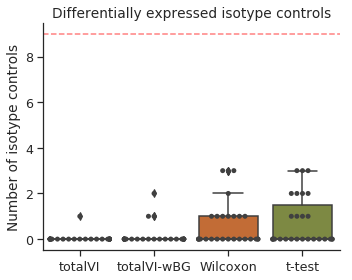

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.boxplot(data=data)
sns.swarmplot(data=data, color=".25")
plt.title("Differentially expressed isotype controls")
plt.ylabel("Number of isotype controls")
plt.axhline(9, c="red", alpha=0.5, linestyle="--")
sns.despine()
plt.tight_layout()
plt.savefig("figures/isotypes.pdf")

In [29]:
data

,totalVI,totalVI-wBG,Wilcoxon,t-test
0,0,0,0,0
1,0,0,1,1
2,0,0,0,0
3,0,0,1,3
4,0,0,0,0
5,0,0,0,0
6,0,0,1,2
7,0,0,0,0
8,0,0,0,1
9,0,0,0,0
